This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import wisps

import matplotlib as mpl

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
#par = plt.hist2d(np.arange(20), np.arange(1000), norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)

In [3]:
#some functions 
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.concat([pd.Series(x.indices), pd.Series(x.mags), pd.Series(x.snr)])
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]
#change f-test definition
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [4]:
cands=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')

In [5]:
#use the same columns for all data sets
alldata=wisps.get_big_file()
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])

cands['line_chi']=cands.spectra.apply(lambda x : x.line_chi)
cands['spex_chi']=cands.spectra.apply(lambda x: x.spex_chi)
cands['f_test']=cands.spectra.apply(lambda x: x.f_test)

spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)
spex_df['spt']=np.vstack(spex_df['spt'].values)[:,0]
manj['spt']=np.vstack(manj['spt'].values)[:,0]
schn['spt']=np.vstack(schn['spt'].values)[:,0]

cands.grism_id=cands.grism_id.apply(lambda x: x.lower())

cands['spt']=np.vstack(cands['spt'].values)
                           

In [6]:
#add x values 
spex['x']=spex.spex_chi/spex.line_chi
alldata['x']=alldata.spex_chi/alldata.line_chi
cands['x']=cands.spex_chi/cands.line_chi

spex['f_test']=f_test_fx(spex.x.values, spex.dof.values-1, spex.dof.values-2)
alldata['f_test']=f_test_fx(alldata.x.values, alldata.nG141.values-1, alldata.nG141.values-2)

alldata=alldata.sort_values('x')
spex=spex.sort_values('x')
cands=cands.sort_values('x')

In [7]:
alldata['datalabel']='alldata'
spex['datalabel']='spex'
cands['datalabel']='ucds'
combined_ftest_df=pd.concat([cands, spex, alldata[(alldata.snr1>=3.) &  (alldata.mstar_flag !=0)]])

In [8]:
#stats.f.cdf(.85564068, 108-1, 108+2)

In [9]:
#list(spex[['x', 'dof']][spex.f_test.values >0.2].values)

In [10]:
spex=spex[np.vstack(spex.spt.values)[:,0] >=17.]

In [11]:
dt=alldata[(alldata.f_test<.005) &   (alldata.snr1>=3.) &  (alldata.mstar_flag !=0)].reset_index(drop=True)
dt['spt']=(dt['spt']).apply(wisps.make_spt_number).apply(float)

In [12]:
dt=wisps.Annotator.reformat_table(dt).reset_index(drop=True)

In [13]:
len(dt)

5946

In [14]:
len(spex[spex.f_test.values < 0.005])/len(spex)

0.9756911344137273

In [15]:
#

In [16]:
#wisps.Annotator.reformat_table(wisps.datasets['subd'])

In [17]:
#get criteria 
##only run this if new data
crts=sel_crt.save_criteria(conts=dt)
crts=sel_crt.crts_from_file()
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

  0%|          | 0/120 [00:00<?, ?it/s]

...........41 sds 
.............2040 templates


100%|██████████| 120/120 [00:25<00:00,  4.76it/s]


In [18]:
#%%capture
'''
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)
                          
'''


'\ncontamns.style.apply(lambda x: ["background-color: #7FDBFF" \n                          if (i >= 0 and (v < 0.1 \n                                          and v > 0. )) \n                          else "" for i, v in enumerate(x)], axis = 1)\n                          \n'

In [19]:
compls.describe()

,L0-L5,L5-T0,M7-L0,T0-T5,T5-T9,subdwarfs,Y dwarfs
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.996455,0.984851,0.987993,0.996697,0.987266,0.973984,0.978409
std,0.003155,0.003892,0.003282,0.004360,0.012859,0.018091,0.022794
min,0.986706,0.979104,0.979469,0.990991,0.966292,0.951220,0.954545
25%,0.995199,0.982090,0.985507,0.990991,0.977528,0.951220,0.954545
50%,0.998523,0.985075,0.986715,1.000000,0.988764,0.975610,1.000000
75%,0.998523,0.988060,0.990338,1.000000,1.000000,0.975610,1.000000
max,0.998523,0.997015,0.995169,1.000000,1.000000,1.000000,1.000000


In [20]:
#crts

In [21]:
def get_toplowest_contam(subtype):
    return {subtype: contamns.sort_values(k).index[0]}

In [22]:
spex['spt']=np.vstack(spex.spt.values)[:,0]

In [23]:
from tqdm import tqdm

In [24]:
def multiplte_indices_selection(k):
    stat_dict={}
    indices= [crts[index_name] for index_name in to_use[k]]
    #make selections for each index separately
    cand_bools=[]
    spex_bools=[]
    trash_bools=[]
    for idx in indices:
        xkey=idx.xkey
        ykey=idx.ykey
        bx=[x for x in idx.shapes if x.shape_name==k][0]
        _, cbools=bx._select(np.array([cands[xkey].values,cands[ykey].values]))
        _, spbools=bx._select(np.array([spex[xkey].values,spex[ykey].values]))
        _, trbools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
        
        cand_bools.append(cbools)
        spex_bools.append(spbools)
        trash_bools.append(trbools)
        
    cands_in_that_class_bool=cands.spt.apply(lambda x: wisps.is_in_that_classification(x, k))
    spex_in_that_class_bool=spex.spt.apply(lambda x: wisps.is_in_that_classification(x, k))

    cand_bools.append(cands_in_that_class_bool)
    spex_bools.append(spex_in_that_class_bool)
    
    cands_selected=cands[np.logical_and.reduce(cand_bools, axis=0)]
    spexs_selected=spex[np.logical_and.reduce(spex_bools, axis=0)]
    
    print (' {} selected {} out of {} UCDS'.format(k, len( cands_selected), len(cands[cands_in_that_class_bool])))
    print ('overall completeness {}'.format( len(spexs_selected)/len(spex[spex_in_that_class_bool])))
    print ('total contaminants {}'.format(len(dt[np.logical_and.reduce(trash_bools)])))
    print ('-------------------------------------------')

In [25]:
#for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs']:
#    multiplte_indices_selection(k)

In [26]:
contamns.idxmin(axis=0)

L0-L5               H_2O-1/J-Cont H_2O-2+CH_4/H-Cont
L5-T0        H_2O-1+H_2O-2/H-Cont H_2O-1+CH_4/J-Cont
M7-L0               H_2O-1/J-Cont H_2O-2+CH_4/H-Cont
T0-T5             H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont
T5-T9        H_2O-1+H_2O-2/J-Cont H_2O-1+CH_4/H-Cont
subdwarfs      H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont
Y dwarfs            CH_4/H-Cont H_2O-1+H_2O-2/J-Cont
dtype: object

In [27]:
from collections import OrderedDict
ordered=[(k, contamns.idxmin(axis=0)[k]) for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs', 'subdwarfs']]
to_use=  [ (y, x) for x, y in ordered]

In [28]:
to_use

[('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('H_2O-1+H_2O-2/H-Cont H_2O-1+CH_4/J-Cont', 'L5-T0'),
 ('H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont', 'T0-T5'),
 ('H_2O-1+H_2O-2/J-Cont H_2O-1+CH_4/H-Cont', 'T5-T9'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/J-Cont', 'Y dwarfs'),
 ('H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont', 'subdwarfs')]

In [29]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [30]:
fp={}

In [31]:
cands=cands[cands.grism_id.isin(dt.grism_id)]

In [32]:
#RENAME BOXES
box_renames={'M7-L0':'M7-M9', 
            'L0-L5': 'L0-L4', 
            'L5-T0': 'L5-T0',
            'T0-T5': 'T0-T4',
            'T5-T9': 'T5-T9',
            'Y dwarfs':'Y dwarfs',
            'subdwarfs':'subdwarfs'}

In [33]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17
    print ('templates selected {}'.format(len(to_use_df)))
    print (bx.xrange, bx.yrange)
    xlim=[ bx.xrange[0]-abs(np.ptp(bx.xrange)), bx.xrange[1]+abs(np.ptp(bx.xrange))]
    ylim=[ bx.yrange[0]-abs(np.ptp(bx.yrange)), bx.yrange[1]+abs(np.ptp(bx.yrange))]
    
    #remove nans from background
    bckgrd= dt[[xkey, ykey]].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()
   # ax.scatter(bckgrd[xkey], bckgrd[ykey], s=1, c='#111111', label='Background')
    
    bckgrd=bckgrd[(bckgrd[xkey].between(xlim[0], xlim[1])) & (bckgrd[ykey].between(ylim[0], ylim[1]))]

    h=ax.hist2d(bckgrd[xkey].apply(float).values, bckgrd[ykey].apply(float).values, \
                cmap='binary', norm=mpl.colors.LogNorm( vmin=10, vmax=1000), bins=15)
    
    cands_slctd, cands_bools=bx._select(np.array([cands[xkey].values,cands[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    #simul_slctd, simul_bools=bx._select(np.array([simulated_data[xkey].values, simulated_data[ykey].values]))
    
    print ('real selected', len(cands_slctd[0]), len((cands)))
    cands_in_that_class_bool=(cands).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    #simulated_in_that_class_bool=(simulated_data[simul_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
   
    
    cands_in_that_class=np.array([cands_slctd[0], \
                                  cands_slctd[1]])
    
    #simulated_in_that_class= np.array([simul_slctd[0][simulated_in_that_class_bool], simul_slctd[1][simulated_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])
    

    #ax.scatter( simulated_in_that_class[0],    simulated_in_that_class[1], facecolors='none', s=10, 
    #           edgecolors='#001f3f', label='simulated')
    
    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1],  facecolors='none',\
               edgecolors='#0074D9',  label='Templates', s=50.)

    #ax.scatter(cands[xkey], cands[ykey], marker='x', facecolors='#FF851B', s=40., alpha=0.5)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker ='+',  s=150., alpha=1.,
               facecolors='#FF851B', label='Discovered UCDs')
    ax.scatter(cands[xkey].values, cands[ykey].values, marker='+',  s=150., alpha=0.3,
               facecolors='#FF851B')
    
    
    bx.color='None'
    bx.alpha=1.
    bx.linewidth=3
    bx.linestyle='-'
    bx.edgecolor='#0074D9'
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    #cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
    #cb.set_label('Counts in bin', fontsize=16)
    
    plt.tight_layout()
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=14)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=14)
    
    ax.set_title(box_renames[box_name], fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
   
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.tight_layout()
    #print (' {} background selected {}'.format(box_name, len(bx.select( bckgrd))))
    
    return {str(box_name): bx}
    
    

In [34]:
to_use

[('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('H_2O-1+H_2O-2/H-Cont H_2O-1+CH_4/J-Cont', 'L5-T0'),
 ('H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont', 'T0-T5'),
 ('H_2O-1+H_2O-2/J-Cont H_2O-1+CH_4/H-Cont', 'T5-T9'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/J-Cont', 'Y dwarfs'),
 ('H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont', 'subdwarfs')]

In [35]:
idx=crts[to_use[1][0]]

In [36]:
len(idx.subdwarfs), 

(41,)

In [37]:
import matplotlib

0 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0')
templates selected 2566
[0.8319807765387286, 1.06607229010348] [1.4236190942025226, 2.4940797624460602]
real selected 106 161


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


1 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5')
templates selected 2566
[0.675720615267807, 0.9645776058866704] [0.8982507027784781, 2.6083531813083924]
real selected 40 161
2 ('H_2O-1+H_2O-2/H-Cont H_2O-1+CH_4/J-Cont', 'L5-T0')
templates selected 2566
[0.7859488129004027, 1.806346626822223] [0.5778500257938131, 2.8578424574864023]
real selected 16 161
3 ('H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont', 'T0-T5')
templates selected 2566
[-0.09940376337266377, 0.3425648101656743] [-0.7708604777362931, 2.49591469875538]
real selected 13 161
4 ('H_2O-1+H_2O-2/J-Cont H_2O-1+CH_4/H-Cont', 'T5-T9')
templates selected 2566
[-0.0449986568560119, 0.3630733695070878] [-0.3223906805166494, 0.5985561308645395]
real selected 3 161
5 ('CH_4/H-Cont H_2O-1+H_2O-2/J-Cont', 'Y dwarfs')
templates selected 42
[-0.18533704327579253, 0.32262049344220206] [-0.796877955726407, 0.7981340107582743]
real selected 3 161
6 ('H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont', 'subdwarfs')
templates selected 41
[1.3462105823375978, 1.8637

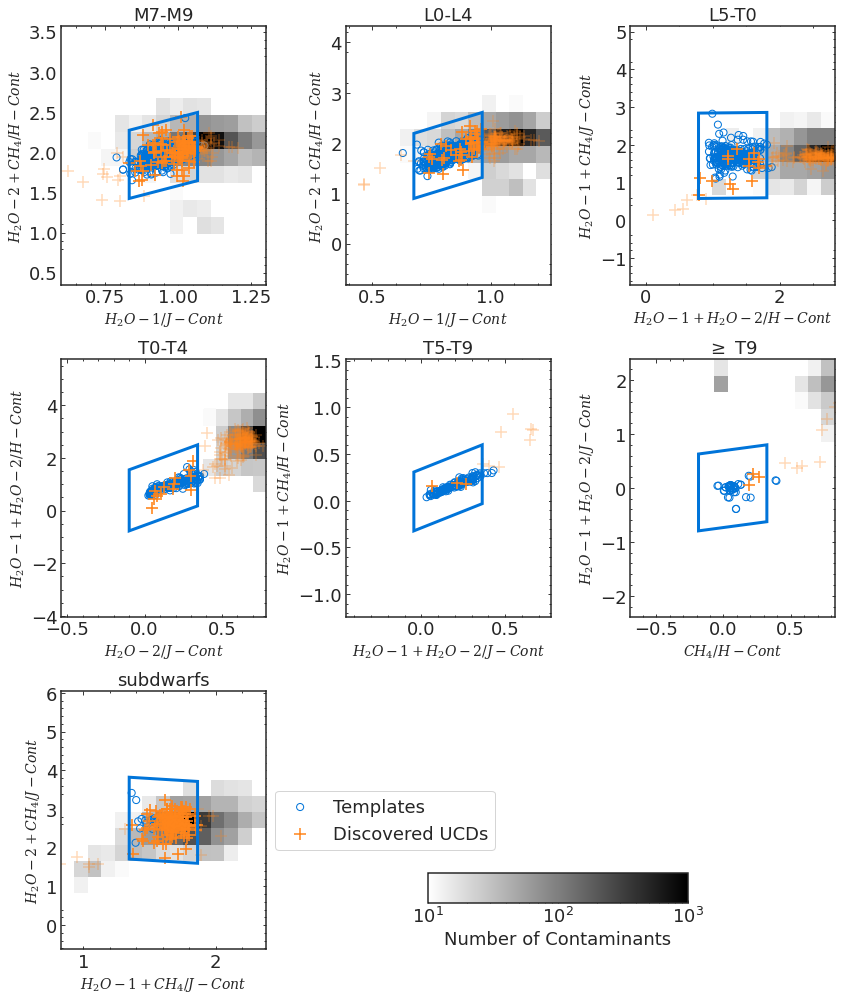

In [38]:
fig, ax=plt.subplots(nrows=3, ncols=3, figsize=(12, 14))

bxs=[]
for idx, k in enumerate(to_use):
    print (idx, k)
    b=plot_index_box( k[0], k[1], np.concatenate(ax)[idx])
    bxs.append(b)



plt.tight_layout()

cax = fig.add_axes([0.5, 0.1, .3, 0.03])
norm= mpl.colors.LogNorm( vmin=10, vmax=1000)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='binary')# vmin=10, vmax=5000)
cbar=plt.colorbar(mp, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel(r'Number of Contaminants', fontsize=18)


fig.delaxes(np.concatenate(ax)[-1])
fig.delaxes(np.concatenate(ax)[-2])



np.concatenate(ax)[-4].set_title(r'$\geq$ T9 ', fontsize=18)
#subdindx_index_crt=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']
#subdrfs=wisps.Annotator.reformat_table(dummy_index_crt.subdwarfs)
#tpls=wisps.Annotator.reformat_table(spex_df[spex_df.metallicity_class.isna()])
#a=np.concatenate(ax)[-1]
#tpls=tpls[tpls.spt>16]

#a.scatter(dt[subdindx_index_crt.xkey], dt[subdindx_index_crt.ykey], s=1., c='#111111', alpha=0.1)
#a.scatter(tpls[subdindx_index_crt.xkey], tpls[subdindx_index_crt.ykey], marker='+', facecolors='#0074D9',  label='SpeX', s=5.)
#a.scatter(subdrfs[subdindx_index_crt.xkey], subdrfs[subdindx_index_crt.ykey], marker='+', facecolors='#2ECC40',  label='SpeX', s=30.)


#a.set_xlim([0., 1.35])
#a.set_ylim([0., 1.25])
#a.set_title('subdwarfs', fontsize=18)
#a.set_xlabel(r'$'+str(subdindx_index_crt.name.split(' ')[0])+'$', fontsize=15)
#a.set_ylabel(r'$'+str(subdindx_index_crt.name.split(' ')[1])+'$', fontsize=15)

np.concatenate(ax)[-3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.pdf', 
            bbox_inches='tight', rasterized=True,  dpi=150)

In [39]:
to_use

[('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('H_2O-1+H_2O-2/H-Cont H_2O-1+CH_4/J-Cont', 'L5-T0'),
 ('H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont', 'T0-T5'),
 ('H_2O-1+H_2O-2/J-Cont H_2O-1+CH_4/H-Cont', 'T5-T9'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/J-Cont', 'Y dwarfs'),
 ('H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont', 'subdwarfs')]

In [40]:
#.grism_id.to_csv('/users/caganze/desktop/true_brown_dwarfs.csv')

In [41]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [42]:
#invert to use
inv_to_use = {v: k for k, v in to_use}

In [43]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [44]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))
cands.grism_id=cands.grism_id.apply(lambda x: x.lower().strip())
good_indices=[crts[x] for x in inv_to_use.values()]

In [45]:
len(candsss), len(candsss[candsss.grism_id.isin(cands.grism_id.apply(lambda x: x.lower().strip())) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(3400, 157)

In [46]:
len(candsss.drop_duplicates('grism_id'))/len(alldata)

0.013371928389390554

In [47]:
len(candsss[candsss.grism_id.isin(cands.grism_id) & (candsss.spt.apply(wisps.make_spt_number).between(35, 40))])

4

In [48]:
len(candsss), len(dt), len(alldata[alldata.mstar_flag !=0])

(3400, 5946, 46561)

In [49]:
len(dt)/len(alldata)

0.023385143000975363

In [50]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [51]:
#print out table
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

for index, k in to_use:
    spt_range=k
    sindex=crts[index]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 7),
                                                                           round(fp[spt_range],6)))
    

 M7-L0 & H_2O-1/J-Cont &  H_2O-2+CH_4/H-Cont & (0.83, 2.27) & (1.07, 2.49) & (1.07, 1.65) & (0.83, 1.42) & 0.99 & 0.1639261  & 0.890383 \\ 
 L0-L5 & H_2O-1/J-Cont &  H_2O-2+CH_4/H-Cont & (0.68, 2.19) & (0.96, 2.61) & (0.96, 1.32) & (0.68, 0.9) & 1.0 & 0.0700119  & 0.903148 \\ 
 L5-T0 & H_2O-1+H_2O-2/H-Cont &  H_2O-1+CH_4/J-Cont & (0.79, 2.84) & (1.81, 2.86) & (1.81, 0.6) & (0.79, 0.58) & 1.0 & 0.037336  & 0.927928 \\ 
 T0-T5 & H_2O-2/J-Cont &  H_2O-1+H_2O-2/H-Cont & (-0.1, 1.55) & (0.34, 2.5) & (0.34, 0.18) & (-0.1, -0.77) & 1.0 & 0.013042  & 0.831169 \\ 
 T5-T9 & H_2O-1+H_2O-2/J-Cont &  H_2O-1+CH_4/H-Cont & (-0.04, 0.31) & (0.36, 0.6) & (0.36, -0.03) & (-0.04, -0.32) & 1.0 & 0.0006774  & 0.25 \\ 
 Y dwarfs & CH_4/H-Cont &  H_2O-1+H_2O-2/J-Cont & (-0.19, 0.63) & (0.32, 0.8) & (0.32, -0.63) & (-0.19, -0.8) & 0.95 & 0.0006782  & 0.25 \\ 
 subdwarfs & H_2O-1+CH_4/J-Cont &  H_2O-2+CH_4/J-Cont & (1.35, 3.82) & (1.86, 3.71) & (1.86, 1.6) & (1.35, 1.71) & 1.0 & 0.5033636  & 1.0 \\ 


In [52]:
len(candsss), len(dt)

(3400, 5946)

In [53]:
#ghjk

In [54]:
stars= alldata[alldata.mstar_flag !=0]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


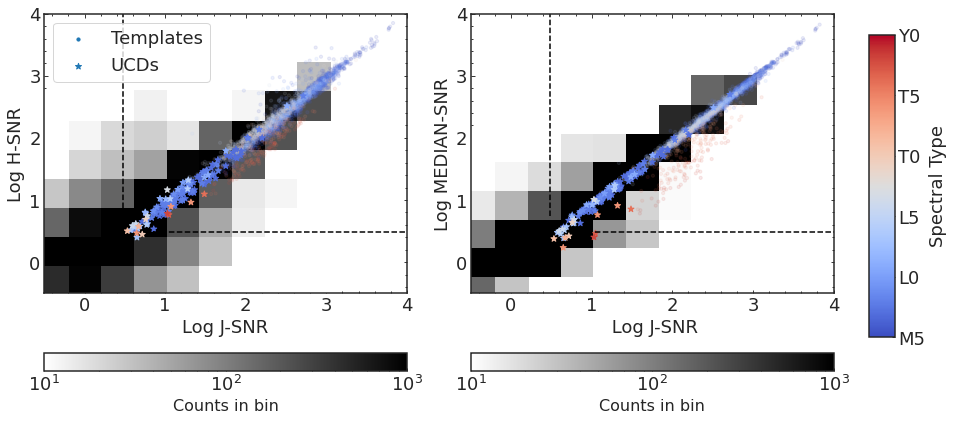

In [55]:
cands_dff=(cands[np.logical_and(cands['snr1'] >=3., cands['spt'] >=17)]).sort_values('spt')
spex_df=spex_df.sort_values('spt')

star_snr=stars[['snr1', 'snr2', 'snr3', 'snr4']].apply(np.log10).dropna()
star_snr=(star_snr[star_snr.snr1.between(-1, 4) & star_snr.snr3.between(-1, 4) & star_snr.snr4.between(-1, 4)]).reset_index(drop=True)


fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(12, 6))

h=ax.hist2d(star_snr['snr1'], star_snr['snr3'], cmap='binary',\
            bins=10, label='Point Sources', norm=mpl.colors.LogNorm( vmin=10, vmax=1000))
#ax.scatter(star_snr['snr1'], star_snr['snr3'], c='#111111', s=1, alpha=0.1)
cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
cb.set_label('Counts in bin', fontsize=16)
plt.tight_layout()

#ax.scatter(star_snr['snr1'],  star_snr['snr4'], s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')


ax.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr3'].apply(np.log10),
            s=10, c=spex_df.spt, 
            cmap='coolwarm',  marker='o', alpha=0.1, vmin=15, vmax=40) 
ax.scatter(spex_df['snr1'].apply(np.log10)[0], spex_df['snr3'].apply(np.log10)[0],
            s=10, c=spex_df.spt[0], 
            cmap='coolwarm', label='Templates', marker='o', alpha=1., vmin=15, vmax=40) 
ax.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr3'].apply(np.log10), 
           c=cands_dff['spt'], s=40,  marker='*', cmap='coolwarm', label='UCDs'
           , vmin=15, vmax=40) 
ax.set_xlim([-0.5, 4])
ax.set_ylim([-0.5, 4])
ax.set_xlabel('Log J-SNR', fontsize=18)
ax.set_ylabel('Log H-SNR', fontsize=18)
ax.legend(fontsize=18, loc='upper left')

ax.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')



#ax1.scatter(stars['snr1'].apply(np.log10), stars['snr4'].apply(np.log10), s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')
#ax1.scatter(star_snr['snr1'], star_snr['snr4'], c='#111111', s=1, alpha=0.1)
h1=ax1.hist2d(star_snr['snr1'], star_snr['snr4'], cmap='binary', bins=10, label='Point Sources', \
              norm=mpl.colors.LogNorm( vmin=10, vmax=1000))

mp=ax1.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr4'].apply(np.log10), s=10, c=spex_df.spt, 
            cmap='coolwarm', label='Templates',  marker='o', alpha=0.1, vmin=15, vmax=40)

ax1.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr4'].apply(np.log10), 
                       c=cands_dff['spt'], s=40, marker='*', cmap='coolwarm', label='UCDs',  vmin=15, vmax=40) 
ax1.set_xlim([-0.5, 4])
ax1.set_ylim([-0.5, 4])
ax1.set_xlabel(' Log J-SNR', fontsize=18)
ax1.set_ylabel('Log MEDIAN-SNR', fontsize=18)
#ax.legend(fontsize=18)

ax1.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax1.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')

cb1 = plt.colorbar(h1[3], ax=ax1, orientation='horizontal')
cb1.set_label('Counts in bin', fontsize=16)
#plt.tight_layout()
import matplotlib
cax = fig.add_axes([1.01, 0.21, .03, 0.7])
norm= matplotlib.colors.Normalize(vmin=15,vmax=40)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Spectral Type', fontsize=18)

ax.minorticks_on()
ax1.minorticks_on()

cbar.ax.set_yticks([ 17, 20, 25, 30, 35, 40])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_cutplots.pdf', \
            bbox_inches='tight',rasterized=True,  dpi=100)

In [56]:
#import wisps

In [57]:
big=wisps.get_big_file()
bigsnr=big[big.snr1>=3.]

In [58]:
#

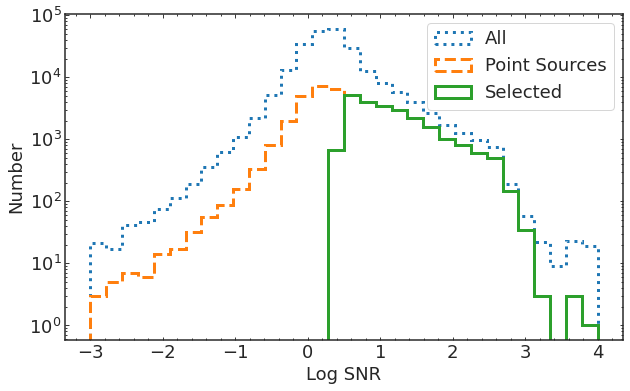

In [59]:
fig, ax=plt.subplots(figsize=(10, 6))
h=ax.hist(big.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step',  linestyle=':', 
          label='All', log=True, linewidth=3)
h=ax.hist(stars.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3, label='Point Sources',
          linestyle='--', log=True)
h=ax.hist(stars[stars.snr1>3].snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3,
          label='Selected',
          log=True)
#h=ax.hist(bigsnr.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3, log=True)
ax.minorticks_on()
plt.xlabel('Log SNR')
plt.ylabel('Number')
plt.legend()
plt.savefig(wisps.OUTPUT_FIGURES+'/snr_distribution.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [60]:
#s3=wisps.Source(filename='goodss-01-G141_47749')
#s4=wisps.Source(filename='goodss-01-G141_45524')

In [61]:
bools=np.logical_and(stars.snr1.between(3, 1000), stars.f_test.between(1e-3, 1))

In [62]:
#s4._best_fit_line

fig, ax=plt.subplots(figsize=(8, 8))
plt.plot(s4.wave, s4.flux, color='#111111', label='Flux')
plt.plot(s4.wave, s4.noise,  '#39CCCC', label='Noise')
std=splat.getStandard(s4.spectral_type[0])
std.normalize(range=[1.2, 1.5])
chi, scale=splat.compareSpectra(s4.splat_spectrum, std,  comprange=[[1.2, 1.5]], statistic='chisqr', scale=True) 
std.scale(scale)
plt.plot(std.wave, std.flux, color='y', label='Best fit template')
plt.plot( s4._best_fit_line[0], color='#FF4136', label='Best fit line')
plt.xlim([1.1, 1.7])
plt.ylim([0, 0.1])
plt.xlabel('Wavelength (micron)')
plt.ylabel('Normalized Flux')
plt.legend()
plt.savefig(wisps.OUTPUT_FIGURES+'/example_line_fit.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [63]:
compls.keys()

Index(['L0-L5', 'L5-T0', 'M7-L0', 'T0-T5', 'T5-T9', 'subdwarfs', 'Y dwarfs'], dtype='object')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


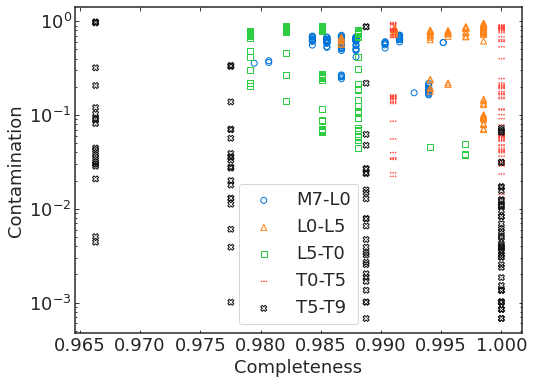

In [64]:
fig, ax=plt.subplots(figsize=(8,6))

#for k in  ['L0-L5', 'L5-T0', 'M7-L0', 'T0-T5', 'T5-T9','subdwarfs']:
ax.scatter(compls['M7-L0'].values, contamns['M7-L0'].values,  facecolors='none', edgecolors='#0074D9', 
           label='M7-L0')
ax.scatter(compls['L0-L5'].values, contamns['L0-L5'].values, marker='^',  facecolors='none',\
           edgecolors='#FF851B', label='L0-L5')

ax.scatter(compls['L5-T0'].values, contamns['L5-T0'].values, marker='s',  facecolors='none',
           edgecolors='#2ECC40', label='L5-T0')

ax.scatter(compls['T0-T5'].values, contamns['T0-T5'].values, marker='$...$',  facecolors='none', 
           edgecolors='#FF4136',
           label='T0-T5')
ax.scatter(compls['T5-T9'].values, contamns['T5-T9'].values, marker='X',  facecolors='none',
           edgecolors='#111111',
           label='T5-T9')
    #h=plt.hist(contams[k].values,  bins='auto', histtype='step',
    #      label='All', log=True, linewidth=3)
ax.set_xlabel('Completeness')
ax.set_ylabel('Contamination')
plt.legend()
ax.set_yscale('log')
plt.savefig(wisps.OUTPUT_FIGURES+'/completeness_contam.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [65]:
compl_contam_table=pd.DataFrame(columns=contamns.columns, index=contamns.index)

In [66]:
for k in compl_contam_table.columns:
    for idx in compl_contam_table.index:
        compl_contam_table.loc[idx, k]=(round(compls.loc[idx, k], 2), \
                                        round(contamns.loc[idx, k], 3))
                                        

In [67]:
(compl_contam_table[['M7-L0', 'L0-L5', 'T0-T5',\
                    'T5-T9', 'Y dwarfs', 'subdwarfs']]).to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} &          M7-L0 &          L0-L5 &          T0-T5 &          T5-T9 &       Y dwarfs &      subdwarfs \\\\\n\\midrule\nH\\_2O-1/J-Cont H\\_2O-2/H\\_2O-1               &  (0.99, 0.201) &     (1.0, 0.1) &   (1.0, 0.031) &  (0.99, 0.001) &   (1.0, 0.001) &  (0.98, 0.618) \\\\\nH\\_2O-1/J-Cont H-cont/H\\_2O-1               &  (0.99, 0.193) &   (1.0, 0.097) &   (1.0, 0.058) &   (1.0, 0.011) &   (1.0, 0.007) &  (0.98, 0.597) \\\\\nH\\_2O-1/J-Cont CH\\_4/H\\_2O-1                 &   (0.99, 0.18) &   (1.0, 0.095) &   (1.0, 0.055) &  (0.99, 0.005) &   (1.0, 0.002) &  (0.98, 0.586) \\\\\nH\\_2O-1/J-Cont H\\_2O-2/J-Cont               &  (0.99, 0.209) &     (1.0, 0.1) &   (1.0, 0.029) &   (1.0, 0.001) &   (1.0, 0.001) &   (0.98, 0.65) \\\\\nH\\_2O-1/J-Cont H-cont/J-Cont               &  (0.99, 0.187) &   (1.0, 0.096) &   (1.0, 0.058) &   (1.0, 0.007) &    (1.0, 0.01) &  (0.98, 0.575) \\\\\nH\\_2O-1/J-Cont CH\\_4/J-Cont                 &  (0.99, 0.173) &   

In [68]:
len(dt)/len(alldata)

0.023385143000975363

In [69]:
sds_nn=pd.read_csv(wisps.LIBRARIES+'/subdarfs_nn_preds.csv')

In [70]:
len(sds_nn)

420

In [71]:
sds_nn_df=alldata[alldata.grism_id.str.lower().isin(sds_nn.grism_id.str.lower())]

In [72]:
len(sds_nn_df[sds_nn_df.mstar_flag==1])

202

In [73]:
pd.read_table('/users/caganze/research/wisps/libraries/candidates_missed.tex')

,\begin{tabular}{lllllrllll}
0,\toprule
1,designation & grism id & ...
2,\midrule
3,J00053715-5012590 & PAR260-00025 & 21....
4,J01000226-5109007 & PAR198-00018 & ...
...,...
78,J23071868+2111362 & PAR166-00004 & ...
79,J23352023-3536432 & PAR359-00020 & 20....
80,J23450387-4239216 & PAR356-00013 & 20....
81,\bottomrule
